In [1]:
%matplotlib notebook

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os

from spykshrk.realtime.simulator import nspike_data

from spykshrk.franklab.pp_decoder.pp_clusterless import OfflinePPDecoder, plot_decode_2d
from spykshrk.franklab.pp_decoder.data_containers import EncodeSettings, DecodeSettings, SpikeObservation, \
                                                         LinearPositionContainer
from spykshrk.franklab.pp_decoder.data_containers import LinearPositionContainer, SpikeObservation

        
%load_ext Cython

%matplotlib inline

#pd.set_option('float_format', '{:,.2f}'.format)
pd.set_option('display.precision', 4)
pd.set_option('display.max_rows', 10)
#pd.set_option('display.width', 180)

idx = pd.IndexSlice


In [2]:
# Load config file and data

config_file = '/home/daliu/Src/spykshrk_realtime/config/bond_single.json'
config = json.load(open(config_file, 'r'))

# Main hdf5 data source file name
hdf_file = os.path.join(config['files']['output_dir'],
                        '{}.rec_merged.h5'.format(config['files']['prefix']))

# Extract just encode and decode settings from config
encode_settings = EncodeSettings(config)
decode_settings = DecodeSettings(config)

# Open data file
store = pd.HDFStore(hdf_file, mode='r')

# Encapsulate Spike Observation panda table in container
observ_obj = SpikeObservation(store['rec_3'])

# Grab stimulation lockout times
stim_lockout = store['rec_11']

# Grab animal linearized real position
nspike_anim = nspike_data.AnimalInfo(**config['simulator']['nspike_animal_info'])
pos = nspike_data.PosMatDataStream(nspike_anim)
pos_data = pos.data

# Encapsulate linear position
lin_obj = LinearPositionContainer(pos_data, encode_settings)

In [3]:
# Linearized position data, example of MultiIndexing pandas table
lin_obj.pos_data

lin_dist_well                          lin_vel                      seg_idx    time  \
                          well_center well_left well_right well_center well_left well_right seg_idx    time   
day epoch timestamp                                                                                           
4   1     73,830,339.0           27.8     142.1      144.5         7.5     134.4      136.4     1.0 2,461.0   
          73,831,341.0           26.9     143.0      145.4         7.5     134.4      136.4     1.0 2,461.0   
          73,832,343.0           25.5     144.3      146.8         6.7     134.5      136.6     1.0 2,461.1   
          73,833,342.0           24.6     145.2      147.7         5.8     134.1      136.1     1.0 2,461.1   
          73,834,344.0           23.3     146.6      149.0         4.9     133.2      135.1     1.0 2,461.1   
...                               ...       ...        ...         ...       ...        ...     ...     ...   
          102,145,374.0           7.0     162.8      165.3        -4.0    -128.6     -130.5     1.0 3,404.8   
          102,146,376.0           7.1     162.8      165.2        -4.2    -131.4     -133.4     1.0 3,404.9   
          102,147,378.0           7.5     162.3      164.8        -4.4    -133.7     -135.7     1.0 3,404.9   
          102,148,377.0           7.5     162.3      164.8        -4.5    -135.4     -137.5     1.0 3,404.9   
          102,149,379.0           7.6     162.3      164.7        -4.7    -136.5     -138.6     1.0 3,405.0   

                                       
                            timestamp  
day epoch timestamp                    
4   1     73,830,339.0   73,830,339.0  
          73,831,341.0   73,831,341.0  
          73,832,343.0   73,832,343.0  
          73,833,342.0   73,833,342.0  
          73,834,344.0   73,834,344.0  
...                               ...  
          102,145,374.0 102,145,374.0  
          102,146,376.0 102,146,376.0  
          102,147,378.0 102,147,378.0  
          102,148,377.0 102,148,377.0  
          102,149,379.0 102,149,379.0  

[28290 rows x 9 columns]

In [4]:
# Up sampling position data to 30 samples/bin, using backfill to interpolate
lin_obj.get_resampled(30)

In [5]:
# Down sampling position data to 30000 samples/bin, dropping data points
lin_obj.get_resampled(30000)

In [6]:
# Observation distribution of each spike in a single epoch. This is calculated and cached from 
# an encoding model in the realtime module. Currently this is only valid for a single epoch's data.

observ_obj.spike_dec

,rec_ind,timestamp,ntrode_id,position,x0,x1,x2,x3,x4,x5,...,x440,x441,x442,x443,x444,x445,x446,x447,x448,x449
0,1,73830048,29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,73830066,13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,73830144,14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6,73830192,14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,73830204,13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303106,237333,102149649,11,7.6,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
303107,55281,102149697,12,7.6,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
303108,96729,102149817,17,7.6,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
303109,237337,102149925,11,7.6,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
# Assign bins (300 samples == 10ms) to each spike based on its timestamp, bins stored as dec_bin column.

observ_obj.get_observations_bin_assigned(300)

,rec_ind,timestamp,ntrode_id,position,x0,x1,x2,x3,x4,x5,...,x442,x443,x444,x445,x446,x447,x448,x449,dec_bin,dec_bin_start
0,1,73830048,29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,73830000
1,1,73830066,13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,73830000
2,2,73830144,14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,73830000
3,6,73830192,14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,73830000
4,5,73830204,13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,73830000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303106,237333,102149649,11,7.6,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,94398,102149400
303107,55281,102149697,12,7.6,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,94398,102149400
303108,96729,102149817,17,7.6,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,94399,102149700
303109,237337,102149925,11,7.6,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,94399,102149700


In [8]:
# For each time bin, compute the product of the distribution stored in columns x0:x449.
# This estimates the probability distribution of position at each time bin. Refer to 
# spykshrk.franklab.pp_decoder.pp_clusterless.OfflinePPDecoder.calc_observation_intensity
# for analysis code that uses groupby.

spike_decode = observ_obj.get_observations_bin_assigned(3000)
groups = spike_decode.groupby('dec_bin')

def prod_dist(df):
    norm_prod = np.ones(450)
    for row in df.loc[:,'x0':'x449'].values:
        norm_prod = norm_prod * row
        norm_prod = norm_prod / norm_prod.sum()
    return pd.DataFrame([norm_prod], columns=['x{}'.format(bin_id) for bin_id in range(450)])

observ_binned = groups.apply(prod_dist)

observ_binned

,,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x440,x441,x442,x443,x444,x445,x446,x447,x448,x449
dec_bin,,,,,,,,,,,,,,,,,,,,,,
0,0,0.0,0.0,0.1,0.7,0.3,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9435,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9436,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9437,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# Convert linearized position segments onto a single axis to match the decoded position mapping.
# This function uses the query command of Panda dataframes.
# e.g.:
# right_pos_flat = (self.pos_data.query('@self.pos_data.seg_idx.seg_idx == 4 | '
#                                       '@self.pos_data.seg_idx.seg_idx == 5').
#                   loc[:, ('lin_dist_well', 'well_right')]) + self.arm_coord[2][0]

single_axis_lin_pos = lin_obj.get_resampled(3000).get_mapped_single_axis()

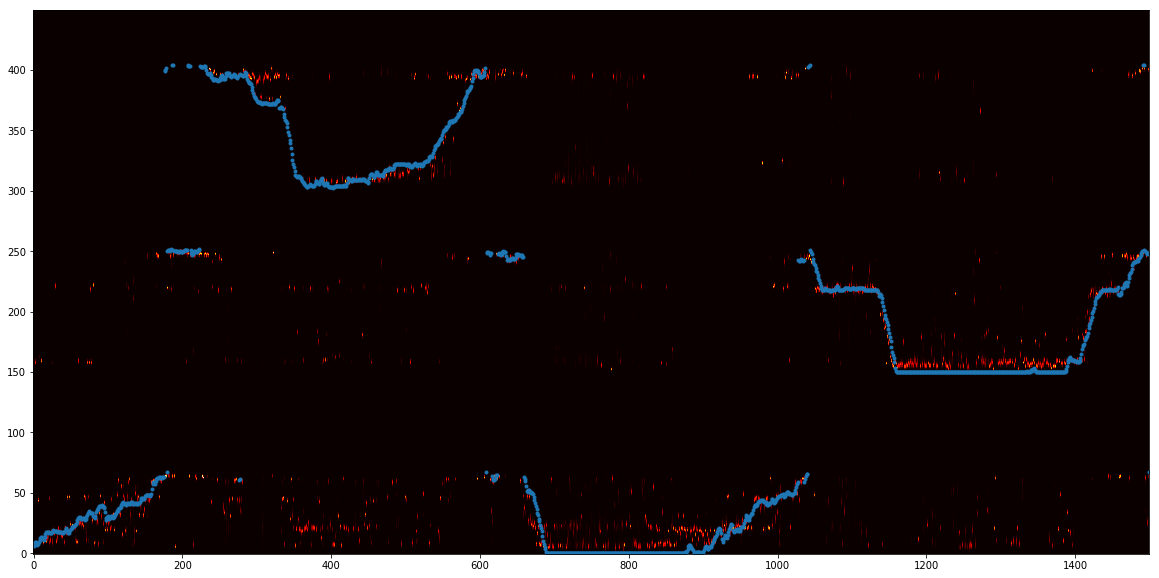

In [10]:
plt.figure(figsize=[20,10])
plt.imshow(observ_binned[2000:3500].T, origin='lower', aspect='auto', cmap='hot', zorder=0)
plt.plot(single_axis_lin_pos.values[2000:3500], '.')
plt.show()